In [97]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import normalize

In [98]:
fig_num = 1

num_epochs = 1

single_example_time = 0.35 * second
resting_time = 0.15 * second

delay = {}
delay = (0*ms, 10*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 1.
start_input_intensity = input_intensity

update_interval = 2

In [99]:
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

neuron_groups = {}
neuron_groups['i']  = NeuronGroup(1, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['e']  = NeuronGroup(1, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')

neuron_groups['i'].v  = v_rest_i - 40.*mV
neuron_groups['e'].v    = v_rest_e - 40.*mV
# 
neuron_groups['e'].theta = np.ones((1)) * 20.0*mV

input_groups = {}
input_groups['input']   = PoissonGroup(1, 0*Hz)

In [100]:
# without STDP
model = 'w : 1'
pre = 'g_e_post += w'
post = ''

connections = {}


# input >> e, without STDP
# one to one connection

connections['input_e']= Synapses(input_groups['input'], neuron_groups['e'], model=model, on_pre=pre, on_post=post)
connections['input_e'].connect(True)
connections['input_e'].w[0] = 25 
connections['input_e'].delay = 'minDelay + rand() * deltaDelay'

# input >> i, without STDP
# one to one connection

connections['input_i']= Synapses(input_groups['input'], neuron_groups['i'], model=model, on_pre=pre, on_post=post)
connections['input_i'].connect(True)
connections['input_i'].w[0] = 25 
connections['input_i'].delay = 'minDelay + rand() * deltaDelay'

# i >> e, without STDP
# one to one connection

connections['i_e']= Synapses(neuron_groups['i'], neuron_groups['e'], model=model, on_pre=pre, on_post=post)
connections['i_e'].connect(True)
connections['i_e'].w[0] = 100 
connections['i_e'].delay = 'minDelay + rand() * deltaDelay'

In [101]:
spike_counter = SpikeMonitor(neuron_groups['e'])

# used for ploting after training
rate_monitors = {}
spike_monitors = {}
state_monitors = {}

rate_monitors['i']        = PopulationRateMonitor(neuron_groups['i'])
rate_monitors['e']        = PopulationRateMonitor(neuron_groups['e'])

spike_monitors['input'] = SpikeMonitor(input_groups['input'])
spike_monitors['e']      = SpikeMonitor(neuron_groups['e'])
spike_monitors['i']      = SpikeMonitor(neuron_groups['i'])

state_monitors['i']   = StateMonitor(neuron_groups['i'], 'v', record=0)
state_monitors['e'] = StateMonitor(neuron_groups['e'], 'v', record=0)

In [102]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, state_monitors]:
    for key in obj_list:
        print(key, obj_list[key])
        net.add(obj_list[key])
print('spike counter', spike_counter)
net.add(spike_counter)

i NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_11')
e NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_12')
input PoissonGroup(1, rates=0. * hertz)
input_e Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_2')
input_i Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_3')
i_e Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_4')
i <PopulationRateMonitor, recording neurongroup_11>
e <PopulationRateMonitor, recording neurongroup_12>
input <SpikeMonitor, recording from spikemonitor_5>
e <SpikeMonitor, recording from spikemonitor_6>
i <SpikeMonitor, recording from spikemonitor_7>
i <StateMonitor, recording ['v'] from neurongroup_11>
e <StateMonitor, recording ['v'] from neurongroup_12>
spike counter <SpikeMonitor, recording from spikemon

In [103]:
previous_spike_count = np.zeros(0)

input_groups['input'].rates = 0 * Hz

net.run(0*second)

j = 0

In [104]:
while j < (num_epochs):
    
    input_groups['input'].rates = 100 * Hz
    
    print('run example number:', j, 'of', num_epochs)
    
    net.run(single_example_time, report='text')   # 0.35 s

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])
    
    if np.sum(current_spike_count) < 1:
        if (input_intensity == 10):
            break;
            
        print("Fail - spike count", np.sum(current_spike_count))
        input_intensity += 1
        
        input_groups['input'].rates = 0 * Hz
        net.run(resting_time) 
    
    else:     
        print("S - spike count", np.sum(current_spike_count))
        
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', num_epochs)

        input_groups['input'].rates = 0 * Hz
        
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

run example number: 0 of 1
Starting simulation at t=0. s for a duration of 0.35 s
0.35 (100%) simulated in 2s
Fail - spike count 0.0
run example number: 0 of 1
Starting simulation at t=0.5 s for a duration of 0.35 s
0.35 (100%) simulated in 2s
S - spike count 8


In [105]:
spike_monitors['e'].count[0]

15

In [106]:
spike_monitors['i'].count[0]

110

In [107]:
spike_monitors['input'].count[0]

70

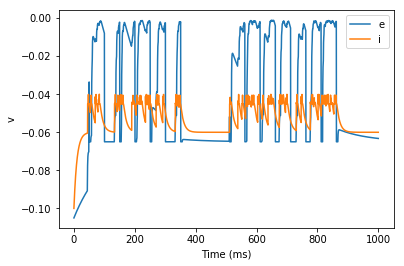

In [108]:
plot(state_monitors['e'].t/ms, state_monitors['e'].v[0], label='e')
plot(state_monitors['i'].t/ms, state_monitors['i'].v[0], label='i')
xlabel('Time (ms)')
ylabel('v')
legend();

In [48]:
connections['input_e'].w[0]

25.0